In [1]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/SAVE/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [2]:
# download the data via link: https://figshare.com/ndownloader/files/24539828

In [3]:
adata = sc.read_h5ad('human_pancreas_norm_complexBatch.h5ad')
adata.obs["batch"] = adata.obs["tech"]
adata.obs["cell_type"] = adata.obs["celltype"]

In [4]:
adata = preprocessing_rna(adata, is_batch_scale=True)

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
batch_scale: 100%|████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


In [5]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

In [6]:
from model.save_model import SAVE

save_model = SAVE(
    adata=adata.copy(),
    is_initialized=True,
    condition_cols=["batch", "cell_type"],
    **kwargs,
)


total col comb is: 3
initialze model weight with seed 1202


In [ ]:
save_model.train(col_msk_threshold=0.2, **kwargs)
save_model.save_ckpt('ckpt/human_pancreas_norm_complexBatch_gen.pt')

In [7]:
save_model.load_ckpt('ckpt/human_pancreas_norm_complexBatch_gen.pt')

successfully load ckpt/human_pancreas_norm_complexBatch_gen.pt!


In [8]:
gen_data = save_model.cond_generate(
    generate_count=500, target_cond={"batch": "celseq", "cell_type": "activated_stellate"}
)

random sampling noise!


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


In [9]:
gen_data

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [12]:
gen_data.obs['cell_type']

0      activated_stellate_gen
1      activated_stellate_gen
2      activated_stellate_gen
3      activated_stellate_gen
4      activated_stellate_gen
                ...          
495    activated_stellate_gen
496    activated_stellate_gen
497    activated_stellate_gen
498    activated_stellate_gen
499    activated_stellate_gen
Name: cell_type, Length: 500, dtype: object

In [10]:
merge_data = sc.concat([adata, gen_data])

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


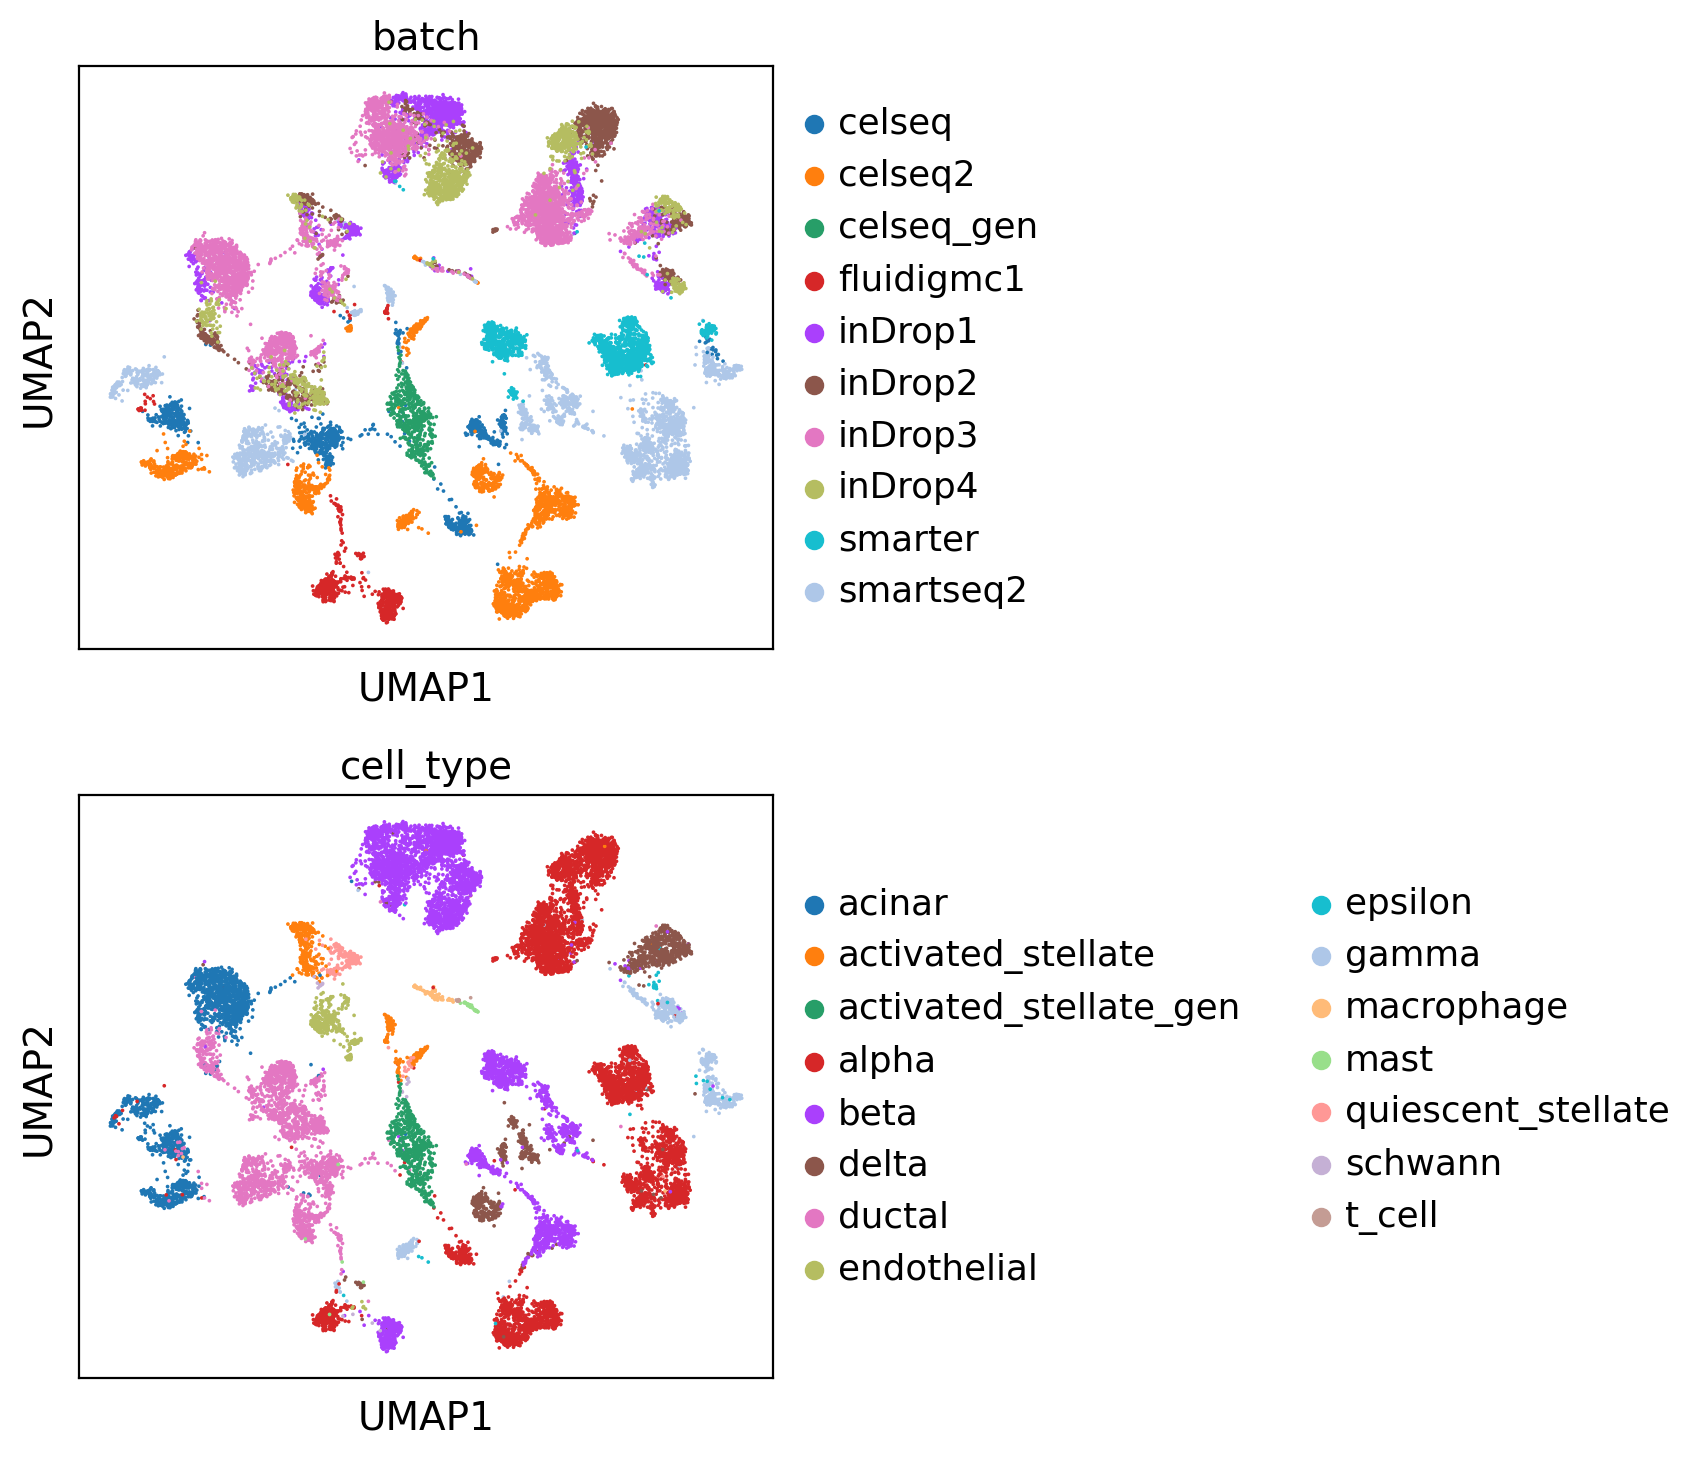

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


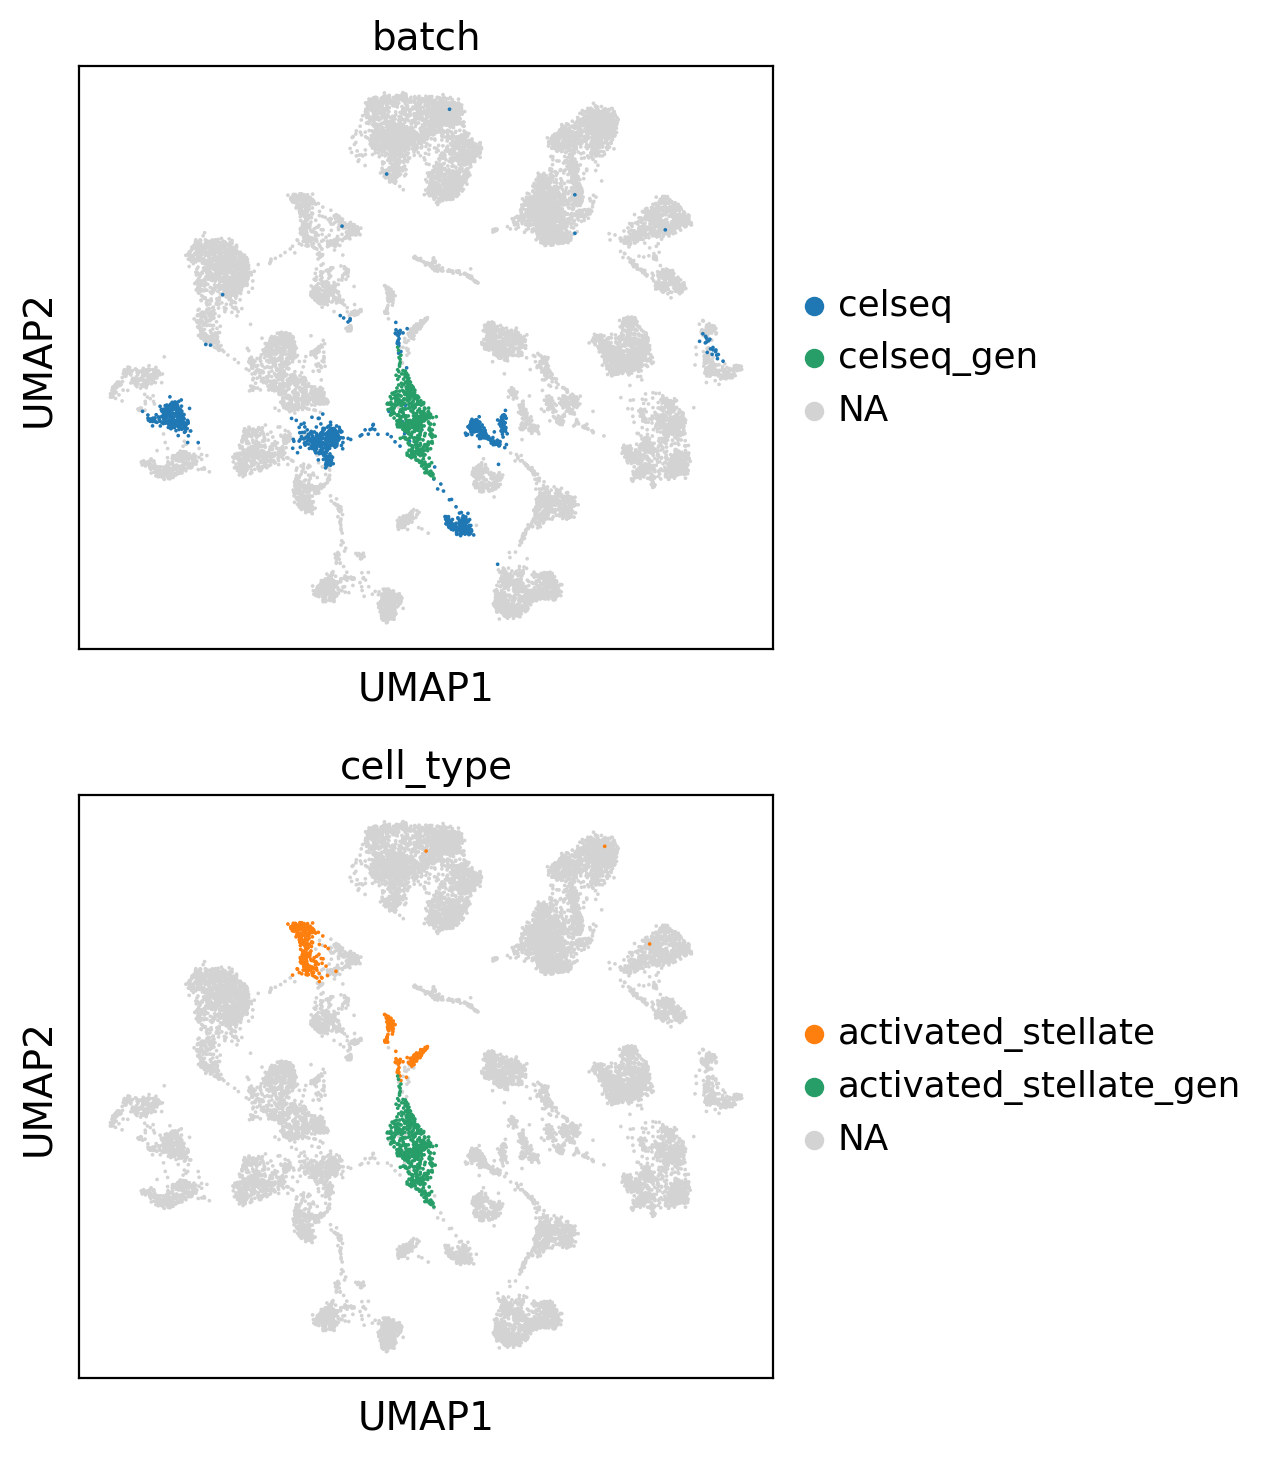

: 

In [14]:
sc.set_figure_params(dpi=100)
sc.pp.pca(merge_data)
sc.pp.neighbors(merge_data)
sc.tl.umap(merge_data)
sc.pl.umap(merge_data, color=["batch", "cell_type"], ncols=1)
# highlight the generated cells
sc.pl.umap(
    merge_data,
    color=["batch", "cell_type"],
    ncols=1,
    groups=["celseq", "celseq_gen", "activated_stellate", "activated_stellate_gen"],
)